In [1]:
from fastai.vision.all import *

In [2]:
DATASET_PATH = Path('RockPaperScissors/data')
DATASET_PATH.ls()

(#5) [Path('RockPaperScissors/data/valid'),Path('RockPaperScissors/data/.DS_Store'),Path('RockPaperScissors/data/Rock-Paper-Scissors'),Path('RockPaperScissors/data/train'),Path('RockPaperScissors/data/test2')]

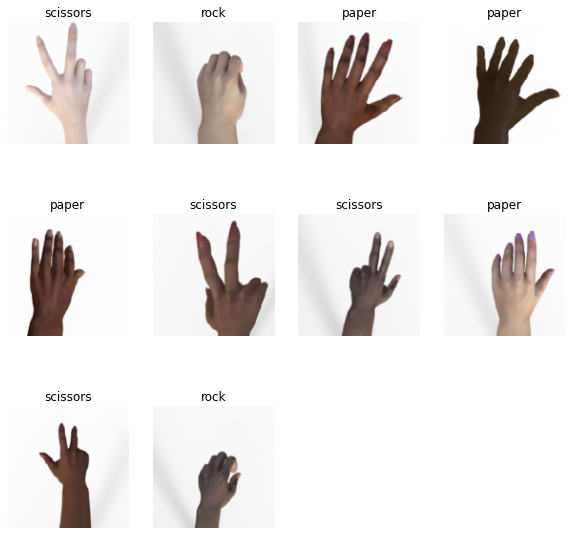

In [3]:
# We are only concerned with train and valid folders
rps_datablock = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = GrandparentSplitter(),
    get_y = parent_label,
    batch_tfms=aug_transforms(size=128, min_scale=0.75)
    )

dls = rps_datablock.dataloaders(DATASET_PATH)
dls.show_batch(max_n=10, figsize=(10,10))

In [4]:
rock_train = (DATASET_PATH/'train'/'rock').ls().sorted()
paper_train = (DATASET_PATH/'train'/'paper').ls().sorted()
scissors_train = (DATASET_PATH/'train'/'scissors').ls().sorted()

In [5]:
rock_train, paper_train, scissors_train

((#840) [Path('RockPaperScissors/data/train/rock/rock01-000.png'),Path('RockPaperScissors/data/train/rock/rock01-001.png'),Path('RockPaperScissors/data/train/rock/rock01-002.png'),Path('RockPaperScissors/data/train/rock/rock01-003.png'),Path('RockPaperScissors/data/train/rock/rock01-004.png'),Path('RockPaperScissors/data/train/rock/rock01-005.png'),Path('RockPaperScissors/data/train/rock/rock01-006.png'),Path('RockPaperScissors/data/train/rock/rock01-007.png'),Path('RockPaperScissors/data/train/rock/rock01-008.png'),Path('RockPaperScissors/data/train/rock/rock01-009.png')...],
 (#840) [Path('RockPaperScissors/data/train/paper/paper01-000.png'),Path('RockPaperScissors/data/train/paper/paper01-001.png'),Path('RockPaperScissors/data/train/paper/paper01-002.png'),Path('RockPaperScissors/data/train/paper/paper01-003.png'),Path('RockPaperScissors/data/train/paper/paper01-004.png'),Path('RockPaperScissors/data/train/paper/paper01-005.png'),Path('RockPaperScissors/data/train/paper/paper01-006.

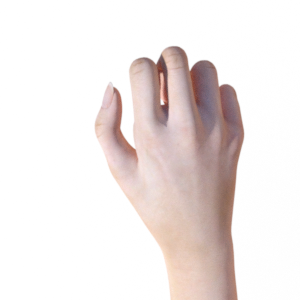

In [101]:
#Pick a random image to view via the PIL library
rock_img = rock_train[3]
img = Image.open(rock_img)
img

In [102]:
img.shape

(300, 300)

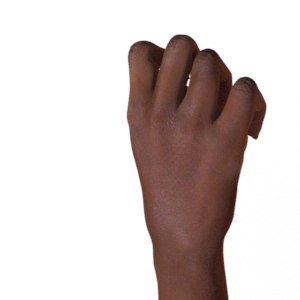

In [7]:
paper_img = rock_train[177]
img = Image.open(paper_img)
img

In [8]:
#what the pytorch tensor looks like
tensor(img)[7:10, 7:10]

tensor([[[255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255]],

        [[254, 254, 254, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255]],

        [[255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255]]], dtype=torch.uint8)

In [100]:
tensor(img).shape

torch.Size([300, 300, 4])

In [91]:
#cumulate all the images of three classes as Pytorch tensors
rock_tensors = [tensor(Image.open(o)) for o in rock_train]
paper_tensors = [tensor(Image.open(o)) for o in paper_train]
scissors_tensors = [tensor(Image.open(o)) for o in scissors_train]

len(rock_tensors), len(paper_tensors), len(scissors_tensors)

(840, 840, 840)

In [104]:
rock_tensors[0].shape

torch.Size([300, 300, 4])

In [92]:
stacked_rock = torch.stack(rock_tensors).float()/255
stacked_paper = torch.stack(paper_tensors).float()/255
stacked_scissors = torch.stack(scissors_tensors).float()/255

stacked_rock.shape, stacked_paper.shape, stacked_scissors.shape

(torch.Size([840, 300, 300, 4]),
 torch.Size([840, 300, 300, 4]),
 torch.Size([840, 300, 300, 4]))

In [93]:
len(stacked_rock.shape)

4

<AxesSubplot:>

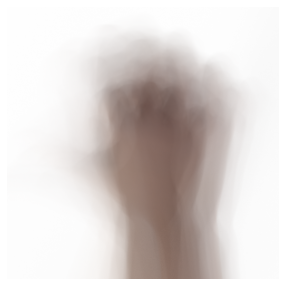

In [96]:
# visualising the ideal rock, paper, scissor image
rock_mean = stacked_rock.mean(0)
show_image(rock_mean)

<AxesSubplot:>

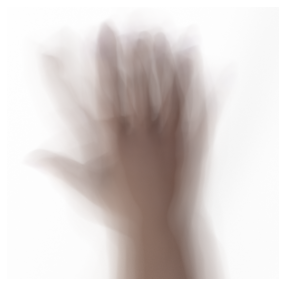

In [13]:
paper_mean = stacked_paper.mean(0)
show_image(paper_mean)

<AxesSubplot:>

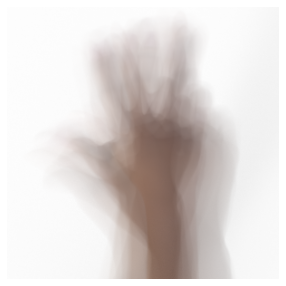

In [14]:
scissors_mean = stacked_scissors.mean(0)
show_image(scissors_mean)

In [15]:
# really hard to tell much difference, hence not recommended approach in real life usage

tensor(0.0942)

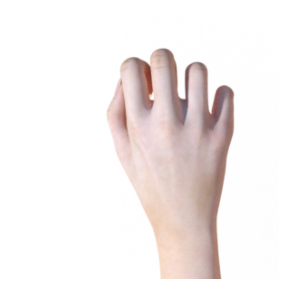

In [65]:
#Calculating the mean absolute difference and root mean squared error

#taking a random rock tensor from stacked rock tensors
rock_rand = stacked_rock[7]
show_image(rock_rand)
mean_abs_rock_rock = (rock_rand - rock_mean).abs().mean()
mean_abs_rock_rock

In [18]:
#now calculating the mean abs distance from a random scissor tensor
scissor_rand = stacked_scissors[19]
mean_abs_rock_scissors = (scissor_rand - rock_mean).abs().mean()
mean_abs_rock_scissors

tensor(0.0866)

In [19]:
#it's less. 

In [20]:
#doing the same with rms
rms_rock_rock = ((rock_rand - rock_mean) ** 2).mean().sqrt()
rms_rock_rock

tensor(0.1697)

In [21]:
rms_rock_scissor = ((scissor_rand - rock_mean) ** 2).mean().sqrt()
rms_rock_scissor

tensor(0.1557)

In [22]:
#again it's less. 

In [23]:
#Using Pytorch function doing the same
F.l1_loss(rock_rand.float(),rock_mean), F.mse_loss(rock_rand,rock_mean).sqrt()

(tensor(0.0942), tensor(0.1697))

In [115]:
# making a custom function to calculate pixel similarities via rms method
def get_pixel_diff(a, b):
    return (a-b).abs().mean((-1, -2, -3))

get_pixel_diff(rock_rand, rock_mean)

tensor(0.0942)

In [124]:
def is_rock(x):
    return (get_pixel_diff(x, rock_mean) < get_pixel_diff(x, paper_mean)) \
        & (get_pixel_diff(x, rock_mean) < get_pixel_diff(x, scissors_mean))

In [125]:
is_rock(rock_rand)

tensor(False)

In [118]:
#calculating accuracy
# get a validation set to calc over first
rock_val = (DATASET_PATH/'valid'/'rock').ls()
paper_val = (DATASET_PATH/'valid'/'paper').ls()
scissors_val = (DATASET_PATH/'valid'/'scissors').ls()

stacked_rock_val = torch.stack([tensor(Image.open(o)) for o in rock_val])
stacked_rock_val = stacked_rock_val.float()/255
stacked_paper_val = torch.stack([tensor(Image.open(o)) for o in paper_val])
stacked_paper_val = stacked_paper_val.float()/255
stacked_scissors_val = torch.stack([tensor(Image.open(o)) for o in scissors_val])
stacked_scissors_val = stacked_scissors_val.float()/255

In [119]:
stacked_rock_val.shape, stacked_paper_val.shape, stacked_scissors_val.shape

(torch.Size([124, 300, 300, 4]),
 torch.Size([124, 300, 300, 4]),
 torch.Size([124, 300, 300, 4]))

In [126]:
valid_rock_dist = get_pixel_diff(rock_mean, stacked_rock_val)
valid_rock_dist

tensor([0.1068, 0.0998, 0.0725, 0.0862, 0.0634, 0.0712, 0.0666, 0.0642, 0.0658,
        0.0707, 0.0917, 0.0686, 0.0932, 0.0707, 0.1018, 0.0667, 0.0895, 0.0596,
        0.0645, 0.0651, 0.0573, 0.0960, 0.0675, 0.0649, 0.0884, 0.1134, 0.0688,
        0.0676, 0.1107, 0.0975, 0.0621, 0.0572, 0.0691, 0.0839, 0.1146, 0.0787,
        0.0696, 0.0807, 0.0808, 0.0703, 0.0708, 0.0758, 0.1139, 0.0591, 0.1072,
        0.1011, 0.1013, 0.1077, 0.1010, 0.1068, 0.1118, 0.1116, 0.1064, 0.1009,
        0.1016, 0.1044, 0.1049, 0.1020, 0.1059, 0.1029, 0.1024, 0.1054, 0.1099,
        0.1095, 0.1088, 0.1034, 0.1039, 0.1091, 0.1084, 0.1107, 0.1119, 0.1103,
        0.1080, 0.1111, 0.1113, 0.0671, 0.0696, 0.1107, 0.0825, 0.1083, 0.0791,
        0.0785, 0.0798, 0.0785, 0.1041, 0.1050, 0.0819, 0.0686, 0.0727, 0.0673,
        0.0916, 0.0802, 0.0770, 0.0799, 0.0805, 0.0757, 0.0808, 0.0984, 0.0657,
        0.1113, 0.0828, 0.0787, 0.0720, 0.0780, 0.0776, 0.0726, 0.0715, 0.0872,
        0.1107, 0.0804, 0.0828, 0.1098, 

In [127]:
valid_rock_dist.shape

torch.Size([124])

In [128]:
accuracy_rock = is_rock(stacked_rock_val)
accuracy_rock

tensor([False, False,  True, False, False, False,  True,  True,  True, False,
         True, False, False,  True, False,  True, False, False,  True,  True,
        False, False,  True, False, False, False,  True,  True, False, False,
        False, False, False, False, False, False,  True, False, False,  True,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False,  True, False, False, False,  True,  True, False, False,
        False, False, False, False])

In [129]:
accuracy_rock.float().mean()
# so bad accuracy

tensor(0.1371)

In [130]:
def is_paper(x):
    return (get_pixel_diff(x, paper_mean) < get_pixel_diff(x, rock_mean)) \
        & (get_pixel_diff(x, paper_mean) < get_pixel_diff(x, scissors_mean))

In [131]:
accuracy_paper = is_paper(stacked_paper).float().mean()
accuracy_paper

tensor(0.5536)

In [ ]:
#accuracy of paper is much better- as paper looks much diff from rock and scissors do with each other. 

In [ ]:
''' this should be true right? 
why does this happen?
Not an efficient system as we'd expected before
need a system of parameters that learns over time, this is an absolute method with no learning at all.

Next up: SGD from scratch. 
'''